In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi']=150
import scipy.spatial
from sklearn.linear_model import LinearRegression

In [2]:
votes = (np.loadtxt('house-votes-84.data', delimiter = ',', dtype =object, unpack=True)).T

In [3]:
def numberer(data):
    X = np.zeros((435,16))
    y = np.zeros(435)
    count = 0
    
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if j == 0:
                if data[i,j] == 'republican':
                    y[count] = 1
                    count += 1
                if data[i,j] == 'democrat':
                    y[count] = -1
                    count += 1
            elif j>0:
                if data[i,j] == 'n':
                    X[i,j-1] = 1
                if data[i,j] == 'y':
                    X[i,j-1] = -1
                if data[i,j] == '?':
                    X[i,j-1] = 0
    return X, y

def eta(tt, sigma):
    val = np.exp(-(tt**2)/(2*sigma**2)) 
    return val.astype(float)

## 1

In [4]:
X, y = numberer(votes)

## 2

In [5]:
step = 0.01
sigma = np.arange(0,4+step,step)
sigma = sigma[1:]
ca = np.zeros((len(sigma)))
caneg = np.zeros((len(sigma)))

for ii in range(len(sigma)):
    dist = scipy.spatial.distance_matrix(X,X,p=2)
    W = eta(dist, sigma[ii])
    D = np.diag(np.sum(W, axis = 1))
    L = D - W

    ll, VV = np.linalg.eigh(L)

    idx = ll.argsort()
    l = ll[idx]
    V = VV[:, idx]

    ypred = np.sign(V[:,1])
    ypredneg = -1*np.sign(V[:,1])
    count = np.count_nonzero(ypred == y)
    countneg = np.count_nonzero(ypredneg == y)
    ca[ii] = (votes.shape[0] - count)/votes.shape[0]
    caneg[ii] = (votes.shape[0] - countneg)/votes.shape[0]

[[3.6, 3.42], [0.11954022988505747, 0.11954022988505747]]


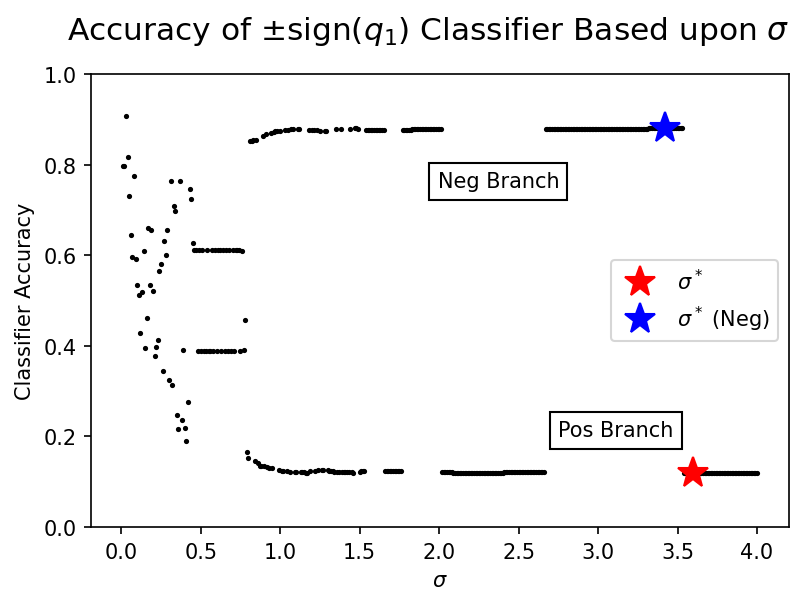

In [6]:
sstaridx = np.where(ca == np.min(ca))
sstarmat = sigma[sstaridx]
sstar = sstarmat[int(np.round(len(sstarmat)/2))]

sstaridxneg = np.where(caneg == np.min(caneg))
sstarnegmat = sigma[sstaridxneg]
sstarneg = sstarnegmat[int(np.round(len(sstarnegmat)/2))]
print([[sstar, sstarneg],[np.min(ca),np.min(caneg)]])

fig, ax = plt.subplots()
ax.plot(sigma, ca, 'ko', ms = 1.5)
ax.plot(sstar,np.min(ca), '*r', label ='$\sigma^*$', ms = 15)
ax.plot(sstarneg, 1 - np.min(caneg), '*b', label = '$\sigma^*$ (Neg)', ms = 15)
ax.set_xlabel('$\sigma$')
ax.set_ylabel('Classifier Accuracy')
ax.set_ylim([0,1])
ax.text(1.99, 0.75, 'Neg Branch', bbox = dict(facecolor = 'white'))
ax.text(2.75, 0.2, 'Pos Branch', bbox = dict(facecolor = 'white'))
ax.legend()
fig.suptitle('Accuracy of $\pm$sign$(q_1)$ Classifier Based upon $\sigma$', size = 15)
plt.show()

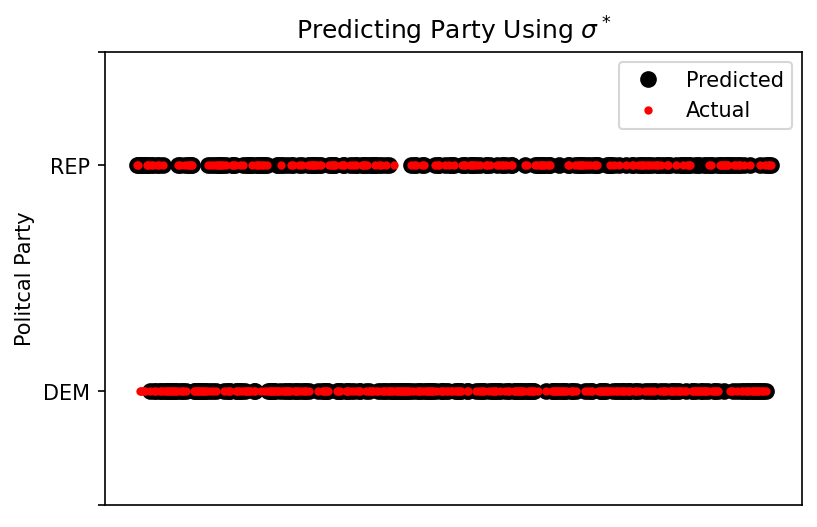

In [7]:
dist = scipy.spatial.distance_matrix(X,X,p=2)
W = eta(dist, sstar)
D = np.diag(np.sum(W, axis = 1))
L = D - W

ll, VV = np.linalg.eigh(L)

idx = ll.argsort()
l = ll[idx]
V = VV[:, idx]

ypred = np.sign(V[:,1])

plt.plot(np.arange(0,435,1), ypred, 'ko', ms = 7, label = 'Predicted')
plt.plot(np.arange(0,435,1), y, 'ro', ms = 3, label = 'Actual')
#plt.plot(np.arange(0,435,1), V[:,1], 'bo', ms = 1, label = 'Raw ')
plt.title('Predicting Party Using $\sigma^*$')
plt.yticks([-2,-1, 1,2], ['','DEM', 'REP',''])
plt.ylabel('Politcal Party')
plt.xticks([])
plt.legend()
plt.show()

## 3

In [8]:
X, y = numberer(votes)

In [18]:
M = [2,3,4,5,6]
J = [5,10,20,40]

SSLacc = np.zeros((len(J), len(M), len(sstarmat)))
mins = np.zeros((len(sstarmat),2))

for kk in range(len(sstarmat)):
    for ii in range(len(M)):
        for jj in range(len(J)):
            LR = LinearRegression(fit_intercept = False)
            
            dist = scipy.spatial.distance_matrix(X,X,p=2)
            W = eta(dist, sstarmat[kk])
            D = np.diag(np.sum(W, axis = 1))
            L = D - W

            ll, VV = np.linalg.eigh(L)

            idx = ll.argsort()
            l = ll[idx]
            V = VV[:, idx]

            F = V[:,:M[ii]]
            A = F[:J[jj],:]
            bhat = y[:J[jj]]

            LR.fit(A,bhat)
            beta = LR.coef_
            yhat = np.sign(np.dot(F,beta))
        
            count = np.count_nonzero(yhat == y)
            SSLacc[jj,ii,kk] = (votes.shape[0] - count)/votes.shape[0]

In [34]:
SSLaccmin = np.amin(SSLacc)
loc = np.array(np.where(SSLaccmin == SSLacc))
minparams = np.array([sstarmat[int(loc[2,15])], M[int(loc[0,15])], J[int(loc[1,15])], SSLaccmin])

print(SSLacc[:,:,int(np.round(len(sstarmat)/2))])
print(minparams)

[[0.13563218 0.09425287 0.47356322 0.3908046  0.47126437]
 [0.13563218 0.14022989 0.08505747 0.2        0.3862069 ]
 [0.12183908 0.10114943 0.09195402 0.09885057 0.10574713]
 [0.12183908 0.10804598 0.09655172 0.07126437 0.08505747]]
[ 3.7         5.         40.          0.07126437]
